# Business Location Selection Based on Population Distribution: Case Study in City of Toronto

## Data

In [1]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
from sklearn import linear_model
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import seaborn as sns
import geocoder 
import folium
from geopy.geocoders import Nominatim
import json

### Extract neighbourhood data

In [2]:
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
html_data  = requests.get(url).text 
soup = BeautifulSoup(html_data,"html5lib") 

In [3]:
table_contents = []
table = soup.find('table')

for row in table.findAll('td'):
    cell = {}
    if row.span.text == 'Not assigned':
        pass
    else:
        cell['PostalCode'] = row.p.text[:3]
        cell['Borough'] = (row.span.text).split('(')[0]
        cell['Neighborhood'] = (((((row.span.text).split('(')[1]).strip(')')).replace(' /',',')).replace(')',' ')).strip(' ')
        table_contents.append(cell)

# print(table_contents)
df = pd.DataFrame(table_contents)
df['Borough'] = df['Borough'].replace({'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto Stn A',
                                             'East TorontoBusiness reply mail Processing Centre969 Eastern':'East Toronto Business',
                                             'EtobicokeNorthwest':'Etobicoke Northwest','East YorkEast Toronto':'East York/East Toronto',
                                             'MississaugaCanada Post Gateway Processing Centre':'Mississauga'})

df.head(5)

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Queen's Park,Ontario Provincial Government


### Adding latitude and longitude to neighbourhood data

In [5]:
geoloc = pd.read_csv(r'C:\Users\nazaraha\Downloads\Capstone_Project\Applied-Data-Science-Capstone\Scripts\Geospatial_Coordinates.csv')
geoloc = geoloc.rename({'Postal Code': 'PostalCode'}, axis=1)  
geoloc.head()

,PostalCode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [6]:
# Adding the latitude and longitude info to df
df = pd.merge(df, geoloc, how = 'inner', on = 'PostalCode')
df.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Queen's Park,Ontario Provincial Government,43.662301,-79.389494


### Plotting the neighbourhoods in Toronto

In [7]:
address = 'Toronto, ON'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


In [8]:
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df['Latitude'], df['Longitude'], df['Borough'], df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

### Extracting population data

In [9]:
pop = pd.read_csv(r'C:\Users\nazaraha\Downloads\Capstone_Project\Applied-Data-Science-Capstone\Scripts\wellbeing_toronto.csv')
pop.drop(["Combined Indicators", "Total Area", "Neighbourhood Id"], axis = 1, inplace = True)
pop.head()

,Neighbourhood,Total Population,Pop - Males,Pop - Females,Child 0-14,Youth 15-24,Pop 15 - 64 years,Chinese,Language - Chinese,Language - Italian,Healthy Food Index,Heritage Sites,Hospital Readmissions,Seniors Living Alone,911 Calls Made by Seniors
0,West Humber-Clairville,33312.0,16625.0,16690.0,5060.0,5445.0,23285.0,470.0,370.0,320.0,23.82,3.0,0.99,160.0,994.0
1,Mount Olive-Silverstone-Jamestown,32954.0,16070.0,16890.0,7090.0,5240.0,22300.0,285.0,170.0,350.0,37.57,1.0,0.81,195.0,740.0
2,Thistletown-Beaumond Heights,10360.0,5055.0,5300.0,1730.0,1410.0,6760.0,110.0,75.0,275.0,42.26,6.0,0.97,105.0,368.0
3,Rexdale-Kipling,10529.0,5130.0,5395.0,1640.0,1355.0,7165.0,165.0,70.0,145.0,23.31,1.0,0.95,115.0,304.0
4,Elms-Old Rexdale,9456.0,4520.0,4935.0,1805.0,1440.0,6370.0,105.0,70.0,190.0,24.71,0.0,0.95,60.0,385.0


### Let's see 5 neighbourhoods with highest population

In [10]:
pop_srt = pop.sort_values(by = 'Total Population', ascending = False)
pop_srt.head(5)

,Neighbourhood,Total Population,Pop - Males,Pop - Females,Child 0-14,Youth 15-24,Pop 15 - 64 years,Chinese,Language - Chinese,Language - Italian,Healthy Food Index,Heritage Sites,Hospital Readmissions,Seniors Living Alone,911 Calls Made by Seniors
76,Waterfront Communities-The Island,65913.0,33295.0,32635.0,3650.0,7840.0,57635.0,9020.0,3250.0,65.0,31.61,1068.0,0.96,485.0,1168.0
136,Woburn,53485.0,25955.0,27520.0,9625.0,7660.0,35835.0,3715.0,2530.0,140.0,27.73,10.0,0.90,495.0,1832.0
50,Willowdale East,50434.0,23680.0,26740.0,5920.0,6940.0,38235.0,16980.0,10500.0,60.0,28.90,7.0,0.91,270.0,1063.0
130,Rouge,46496.0,22475.0,24020.0,7960.0,6700.0,31915.0,2100.0,1015.0,60.0,21.95,36.0,0.67,125.0,886.0
116,L'Amoreaux,43993.0,20600.0,23375.0,6120.0,5730.0,28875.0,16165.0,12245.0,280.0,30.73,3.0,1.02,505.0,1360.0


### Finding the latitude and longitude of each neighbourhood

In [11]:
address = []
location = []
Latitude = []
Longitude = []
count = 0
for i in range(len(pop)):
    try:
        address = pop['Neighbourhood'][i]+', Toronto, Ontario, Canada'
        geolocator = Nominatim(user_agent="foursquare_agent")
        location = geolocator.geocode(address, timeout=10)
        Latitude.append(location.latitude)
        Longitude.append(location.longitude)
    except AttributeError:
        try:
            address = address.replace(', Toronto, Ontario, Canada','').split('-')[0]+', Toronto, Ontario, Canada'
            geolocator = Nominatim(user_agent="foursquare_agent")
            location = geolocator.geocode(address, timeout=10)
            Latitude.append(location.latitude)
            Longitude.append(location.longitude)
        except AttributeError:
            try:
                print(address)
                address = pop['Neighbourhood'][i]+', Toronto, Ontario, Canada'
                print(address)
                address = address.replace(', Toronto, Ontario, Canada','').split('-')[1]+', Toronto, Ontario, Canada'
                print(address)
                geolocator = Nominatim(user_agent="foursquare_agent")
                location = geolocator.geocode(address, timeout=10)
                Latitude.append(location.latitude)
                Longitude.append(location.longitude)
            except IndexError:
                Latitude.append('NaN')
                Longitude.append('NaN')
        
    count += 1
    print(pop['Neighbourhood'][i], '', Latitude[i], Longitude[i])

West Humber-Clairville  43.7225629 -79.59703850234453
Mount Olive-Silverstone-Jamestown  43.65238435 -79.38356765
Thistletown-Beaumond Heights  43.7372656 -79.5653169
Rexdale-Kipling  43.722114149999996 -79.57229244708017
Elms-Old Rexdale  43.72176985 -79.55217331972301
Kingsview Village-The Westway  43.6995391 -79.5563459
Willowridge-Martingrove-Richview  43.6755594 -79.56989551321828
Humber Heights-Westmount  43.6977767 -79.5212217
Edenbridge-Humber Valley  43.6700149 -79.5219478
Princess-Rosethorn  43.6404664 -79.3912237
Eringate-Centennial-West Deane  43.6622732 -79.5765162
Markland Wood  43.63123865 -79.58543401986114
Etobicoke West Mall  43.6435491 -79.56532534553605
Islington-City Centre West  43.645335 -79.5248163
Kingsway South  43.6473811 -79.5113328
Stonegate, Toronto, Ontario, Canada
Stonegate-Queensway, Toronto, Ontario, Canada
Queensway, Toronto, Ontario, Canada
Stonegate-Queensway  43.6236182 -79.5147637
Mimico  43.6166773 -79.4968048
New Toronto  43.6007625 -79.505264
L

In [12]:
pop['Latitude'] = Latitude
pop['Longitude'] = Longitude
pop.head(5)

,Neighbourhood,Total Population,Pop - Males,Pop - Females,Child 0-14,Youth 15-24,Pop 15 - 64 years,Chinese,Language - Chinese,Language - Italian,Healthy Food Index,Heritage Sites,Hospital Readmissions,Seniors Living Alone,911 Calls Made by Seniors,Latitude,Longitude
0,West Humber-Clairville,33312.0,16625.0,16690.0,5060.0,5445.0,23285.0,470.0,370.0,320.0,23.82,3.0,0.99,160.0,994.0,43.7226,-79.597
1,Mount Olive-Silverstone-Jamestown,32954.0,16070.0,16890.0,7090.0,5240.0,22300.0,285.0,170.0,350.0,37.57,1.0,0.81,195.0,740.0,43.6524,-79.3836
2,Thistletown-Beaumond Heights,10360.0,5055.0,5300.0,1730.0,1410.0,6760.0,110.0,75.0,275.0,42.26,6.0,0.97,105.0,368.0,43.7373,-79.5653
3,Rexdale-Kipling,10529.0,5130.0,5395.0,1640.0,1355.0,7165.0,165.0,70.0,145.0,23.31,1.0,0.95,115.0,304.0,43.7221,-79.5723
4,Elms-Old Rexdale,9456.0,4520.0,4935.0,1805.0,1440.0,6370.0,105.0,70.0,190.0,24.71,0.0,0.95,60.0,385.0,43.7218,-79.5522


### Cleaning dataframe pop (removing neighbourhoods without location)

In [13]:
indx_rm = np.where(pop['Latitude'] == 'NaN')[0].tolist()
pop.drop(pop.index[indx_rm], inplace = True)
pop.reset_index(inplace = True)
pop.drop(columns = 'index', inplace = True)
pop.head(5)

,Neighbourhood,Total Population,Pop - Males,Pop - Females,Child 0-14,Youth 15-24,Pop 15 - 64 years,Chinese,Language - Chinese,Language - Italian,Healthy Food Index,Heritage Sites,Hospital Readmissions,Seniors Living Alone,911 Calls Made by Seniors,Latitude,Longitude
0,West Humber-Clairville,33312.0,16625.0,16690.0,5060.0,5445.0,23285.0,470.0,370.0,320.0,23.82,3.0,0.99,160.0,994.0,43.7226,-79.597
1,Mount Olive-Silverstone-Jamestown,32954.0,16070.0,16890.0,7090.0,5240.0,22300.0,285.0,170.0,350.0,37.57,1.0,0.81,195.0,740.0,43.6524,-79.3836
2,Thistletown-Beaumond Heights,10360.0,5055.0,5300.0,1730.0,1410.0,6760.0,110.0,75.0,275.0,42.26,6.0,0.97,105.0,368.0,43.7373,-79.5653
3,Rexdale-Kipling,10529.0,5130.0,5395.0,1640.0,1355.0,7165.0,165.0,70.0,145.0,23.31,1.0,0.95,115.0,304.0,43.7221,-79.5723
4,Elms-Old Rexdale,9456.0,4520.0,4935.0,1805.0,1440.0,6370.0,105.0,70.0,190.0,24.71,0.0,0.95,60.0,385.0,43.7218,-79.5522


### Ploting the Toronto population distribution

In [14]:
pop_total = pop.loc[:,["Neighbourhood", "Total Population","Latitude", "Longitude"]]
pop_total["Pop Ratio"] = 20*(pop_total["Total Population"]/pop_total["Total Population"].max())#
pop_total.head(5)

,Neighbourhood,Total Population,Latitude,Longitude,Pop Ratio
0,West Humber-Clairville,33312.0,43.7226,-79.597,10.107869
1,Mount Olive-Silverstone-Jamestown,32954.0,43.6524,-79.3836,9.999241
2,Thistletown-Beaumond Heights,10360.0,43.7373,-79.5653,3.143538
3,Rexdale-Kipling,10529.0,43.7221,-79.5723,3.194817
4,Elms-Old Rexdale,9456.0,43.7218,-79.5522,2.869237


In [15]:
address = 'Toronto, ON'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

map_toronto2 = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, neighborhood, p, pop_ratio in zip(pop_total['Latitude'], pop_total['Longitude'], pop_total['Neighbourhood'], pop_total['Total Population'], pop_total['Pop Ratio']):
    label = '{}, {}, {}'.format(neighborhood, "population = ", p)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=pop_ratio,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto2)  

map_toronto3 = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, neighborhood, p, pop_ratio in zip(pop_total['Latitude'], pop_total['Longitude'], pop_total['Neighbourhood'], pop_total['Total Population'], pop_total['Pop Ratio']):
    label = '{}, {}, {}'.format(neighborhood, "population = ", p)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=pop_ratio,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto3)      
    
map_toronto2

### Get maximum of 100 venues for each neighbourhood

In [16]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [17]:
CLIENT_ID = '21CCJ411QATXMNQLBM5UKVWZFQHAWIPM0H25APY1JGZGQJZR' # your Foursquare ID
CLIENT_SECRET = 'H3SL3UVP2E5DK2K5TFIGHRATPTQENAATAXHXDPLDXWOBNMVX' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

LIMIT = 100 # A default Foursquare API limit value
radius = 500 # define radius

venues = getNearbyVenues(names = pop['Neighbourhood'],
                                   latitudes = pop['Latitude'],
                                   longitudes = pop['Longitude'])

West Humber-Clairville
Mount Olive-Silverstone-Jamestown
Thistletown-Beaumond Heights
Rexdale-Kipling
Elms-Old Rexdale
Kingsview Village-The Westway
Willowridge-Martingrove-Richview
Humber Heights-Westmount
Edenbridge-Humber Valley
Princess-Rosethorn
Eringate-Centennial-West Deane
Markland Wood
Etobicoke West Mall
Islington-City Centre West
Kingsway South
Stonegate-Queensway
Mimico
New Toronto
Long Branch
Alderwood
Humber Summit
Pelmo Park-Humberlea
Black Creek
Glenfield-Jane Heights
Downsview-Roding-CFB
York University Heights
Rustic
Maple Leaf
Brookhaven-Amesbury
Yorkdale-Glen Park
Englemount-Lawrence
Bathurst Manor
Westminster-Branson
Newtonbrook West
Willowdale West
Lansing-Westgate
Bedford Park-Nortown
St.Andrew-Windfields
Bridle Path-Sunnybrook-York Mills
Banbury-Don Mills
Victoria Village
Flemingdon Park
Parkwoods-Donalda
Pleasant View
Don Valley Village
Hillcrest Village
Bayview Woods-Steeles
Newtonbrook East
Willowdale East
Bayview Village
Henry Farm
O'Connor-Parkview
Thorncli

#### Checking the found venues

In [19]:
print('There are {} uniques categories.'.format(len(venues['Venue Category'].unique())))
venues.head(5)

There are 268 uniques categories.


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,West Humber-Clairville,43.722563,-79.597039,Fortinos,43.721438,-79.596291,Grocery Store
1,West Humber-Clairville,43.722563,-79.597039,Mandarin Buffet,43.720360,-79.594387,Chinese Restaurant
2,West Humber-Clairville,43.722563,-79.597039,New York Fries - Woodbine Centre,43.720568,-79.599609,Restaurant
3,West Humber-Clairville,43.722563,-79.597039,TD Canada Trust,43.719630,-79.599896,Bank
4,West Humber-Clairville,43.722563,-79.597039,Subway,43.720448,-79.600085,Sandwich Place


### Finding total number of venues in each neighbourhood

In [20]:
TotalNumOfNeigh = venues.groupby('Neighborhood').count()
TotalNumOfNeigh.drop(columns = ["Neighborhood Longitude", "Venue", "Venue Latitude", "Venue Longitude", "Venue Category"], axis = 1, inplace = True)
TotalNumOfNeigh.rename(columns = {"Neighborhood Latitude":"Total Num. Venues"}, inplace = True)
TotalNumOfNeigh.head()

,Total Num. Venues
Neighborhood,
Agincourt North,27
Agincourt South-Malvern West,10
Alderwood,7
Annex,39
Banbury-Don Mills,3


### Neighborhoods with maximum number of venues (of any kind)

In [21]:
TotalNumOfNeigh_srt = TotalNumOfNeigh.sort_values(by = 'Total Num. Venues', ascending = False)
TotalNumOfNeigh_srt.head(5)

,Total Num. Venues
Neighborhood,
Bay Street Corridor,100
St.Andrew-Windfields,100
Mount Olive-Silverstone-Jamestown,94
Kensington-Chinatown,80
Old East York,79


### Finding total number of resturants in each neighbourhood

In [22]:
foodrelated = venues[venues['Venue Category'].str.contains('Food|Restaurant|Bakery|Bar|Café|Deli')].reset_index(drop=True)
foodrelated.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,West Humber-Clairville,43.722563,-79.597039,Mandarin Buffet,43.720360,-79.594387,Chinese Restaurant
1,West Humber-Clairville,43.722563,-79.597039,New York Fries - Woodbine Centre,43.720568,-79.599609,Restaurant
2,West Humber-Clairville,43.722563,-79.597039,Bourbon St. Grill,43.720042,-79.600859,Fast Food Restaurant
3,Mount Olive-Silverstone-Jamestown,43.652384,-79.383568,John & Sons Oyster House,43.650656,-79.381613,Seafood Restaurant
4,Mount Olive-Silverstone-Jamestown,43.652384,-79.383568,Tachi,43.650596,-79.383396,Sushi Restaurant


In [23]:
foodrelated = foodrelated.groupby('Neighborhood').count()
foodrelated.drop(columns = ["Neighborhood Longitude", "Venue", "Venue Latitude", "Venue Longitude", "Venue Category"], axis = 1, inplace = True)
foodrelated.rename(columns = {"Neighborhood Latitude":"Num. Food Related"}, inplace = True)
foodrelated.head()

,Num. Food Related
Neighborhood,
Agincourt North,11
Agincourt South-Malvern West,7
Annex,13
Bay Street Corridor,41
Bayview Village,1


### Neighborhoods with maximum number of food-related venues

In [24]:
foodrelated_srt = foodrelated.sort_values(by = 'Num. Food Related', ascending = False)
foodrelated_srt.head(5)

,Num. Food Related
Neighborhood,
St.Andrew-Windfields,44
Bay Street Corridor,41
Kensington-Chinatown,36
Mount Olive-Silverstone-Jamestown,34
Church-Yonge Corridor,32


### Merging total number of venues information into neighbourhood dataframe

In [33]:
pop_venue1 = pd.merge(pop, TotalNumOfNeigh, how = 'left', left_on = 'Neighbourhood', right_on = 'Neighborhood')
pop_venue1.head()

,Neighbourhood,Total Population,Pop - Males,Pop - Females,Child 0-14,Youth 15-24,Pop 15 - 64 years,Chinese,Language - Chinese,Language - Italian,Healthy Food Index,Heritage Sites,Hospital Readmissions,Seniors Living Alone,911 Calls Made by Seniors,Latitude,Longitude,Total Num. Venues
0,West Humber-Clairville,33312.0,16625.0,16690.0,5060.0,5445.0,23285.0,470.0,370.0,320.0,23.82,3.0,0.99,160.0,994.0,43.7226,-79.597,15
1,Mount Olive-Silverstone-Jamestown,32954.0,16070.0,16890.0,7090.0,5240.0,22300.0,285.0,170.0,350.0,37.57,1.0,0.81,195.0,740.0,43.6524,-79.3836,94
2,Thistletown-Beaumond Heights,10360.0,5055.0,5300.0,1730.0,1410.0,6760.0,110.0,75.0,275.0,42.26,6.0,0.97,105.0,368.0,43.7373,-79.5653,12
3,Rexdale-Kipling,10529.0,5130.0,5395.0,1640.0,1355.0,7165.0,165.0,70.0,145.0,23.31,1.0,0.95,115.0,304.0,43.7221,-79.5723,4
4,Elms-Old Rexdale,9456.0,4520.0,4935.0,1805.0,1440.0,6370.0,105.0,70.0,190.0,24.71,0.0,0.95,60.0,385.0,43.7218,-79.5522,5


### Plot Toronto map with population and total venues in each neighbourhood

In [34]:
pop_venue1 = pop_venue1.loc[:,["Neighbourhood", "Latitude", "Longitude", "Total Population", "Total Num. Venues"]]
pop_venue1["Venue Ratio"] = 10*(pop_venue1["Total Num. Venues"]/pop_venue1["Total Num. Venues"].max())
pop_venue1.head(5)

,Neighbourhood,Latitude,Longitude,Total Population,Total Num. Venues,Venue Ratio
0,West Humber-Clairville,43.7226,-79.597,33312.0,15,1.5
1,Mount Olive-Silverstone-Jamestown,43.6524,-79.3836,32954.0,94,9.4
2,Thistletown-Beaumond Heights,43.7373,-79.5653,10360.0,12,1.2
3,Rexdale-Kipling,43.7221,-79.5723,10529.0,4,0.4
4,Elms-Old Rexdale,43.7218,-79.5522,9456.0,5,0.5


In [220]:
# add markers to map
for lat, lng, neighborhood, p, pop_ratio in zip(pop_venue1['Latitude'], pop_venue1['Longitude'], pop_venue1['Neighbourhood'], pop_venue1['Total Num. Venues'], pop_venue1['Venue Ratio']):
    label = '{}, {}, {}'.format(neighborhood, "population:", p, "# of venues:", )
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=pop_ratio,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto2)  
    
map_toronto2

### Merging number of food-related venuesinto neighbourhood dataframe

In [36]:
pop_venue2 = pd.merge(pop, foodrelated, how = 'left', left_on = 'Neighbourhood', right_on = 'Neighborhood')
pop_venue2.head(5)

,Neighbourhood,Total Population,Pop - Males,Pop - Females,Child 0-14,Youth 15-24,Pop 15 - 64 years,Chinese,Language - Chinese,Language - Italian,Healthy Food Index,Heritage Sites,Hospital Readmissions,Seniors Living Alone,911 Calls Made by Seniors,Latitude,Longitude,Num. Food Related
0,West Humber-Clairville,33312.0,16625.0,16690.0,5060.0,5445.0,23285.0,470.0,370.0,320.0,23.82,3.0,0.99,160.0,994.0,43.7226,-79.597,3.0
1,Mount Olive-Silverstone-Jamestown,32954.0,16070.0,16890.0,7090.0,5240.0,22300.0,285.0,170.0,350.0,37.57,1.0,0.81,195.0,740.0,43.6524,-79.3836,34.0
2,Thistletown-Beaumond Heights,10360.0,5055.0,5300.0,1730.0,1410.0,6760.0,110.0,75.0,275.0,42.26,6.0,0.97,105.0,368.0,43.7373,-79.5653,6.0
3,Rexdale-Kipling,10529.0,5130.0,5395.0,1640.0,1355.0,7165.0,165.0,70.0,145.0,23.31,1.0,0.95,115.0,304.0,43.7221,-79.5723,1.0
4,Elms-Old Rexdale,9456.0,4520.0,4935.0,1805.0,1440.0,6370.0,105.0,70.0,190.0,24.71,0.0,0.95,60.0,385.0,43.7218,-79.5522,4.0


### Plot Toronto map with population and food-related venues in each neighbourhood

In [37]:
pop_venue2 = pop_venue2.loc[:,["Neighbourhood", "Latitude", "Longitude", "Total Population", "Num. Food Related"]]
pop_venue2["Venue Ratio"] = 10*(pop_venue2["Num. Food Related"]/pop_venue2["Num. Food Related"].max())
pop_venue2.head(5)

,Neighbourhood,Latitude,Longitude,Total Population,Num. Food Related,Venue Ratio
0,West Humber-Clairville,43.7226,-79.597,33312.0,3.0,0.681818
1,Mount Olive-Silverstone-Jamestown,43.6524,-79.3836,32954.0,34.0,7.727273
2,Thistletown-Beaumond Heights,43.7373,-79.5653,10360.0,6.0,1.363636
3,Rexdale-Kipling,43.7221,-79.5723,10529.0,1.0,0.227273
4,Elms-Old Rexdale,43.7218,-79.5522,9456.0,4.0,0.909091


In [27]:
# add markers to map
for lat, lng, neighborhood, p, pop_ratio in zip(pop_venue2['Latitude'], pop_venue2['Longitude'], pop_venue2['Neighbourhood'], pop_venue2['Num. Food Related'], pop_venue2['Venue Ratio']):
    label = '{}, {}, {}'.format(neighborhood, "population:", p, "# of venues:", )
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=pop_ratio,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto3)  
    
map_toronto3

## Results

## Performing a regression analysis to find the relationship between population and total number of venues in each neighbourhood 

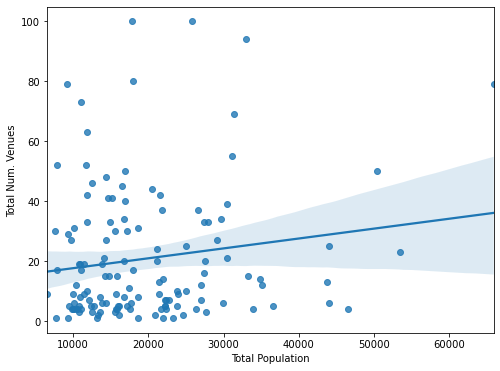

In [35]:
plt.figure(figsize = (8,6),facecolor = 'white')
ax1 = sns.regplot(x = pop_venue1["Total Population"], y = pop_venue1["Total Num. Venues"])

## Correlation between population and total number of venues in each neighbourhood 

In [257]:
print(pop_venue1[["Total Population", "Total Num. Venues"]].corr())

                   Total Population  Total Num. Venues
Total Population            1.00000            0.15292
Total Num. Venues           0.15292            1.00000


## Performing a regression analysis to find the relationship between population and number of food-related venues in each neighbourhood 

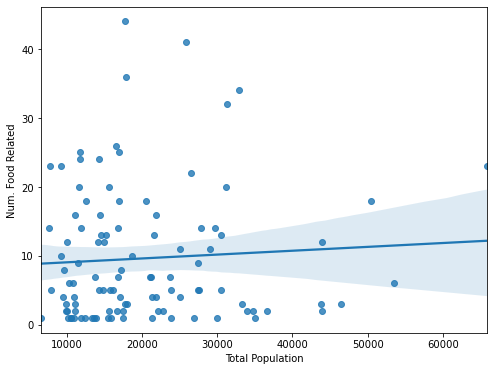

In [38]:
plt.figure(figsize = (8,6),facecolor = 'white')
ax2 = sns.regplot(x = pop_venue2["Total Population"], y = pop_venue2["Num. Food Related"])

## Correlation between population and number of food-related venues in each neighbourhood 

In [260]:
print(pop_venue2[["Total Population", "Num. Food Related"]].corr())

                   Total Population  Num. Food Related
Total Population           1.000000           0.064296
Num. Food Related          0.064296           1.000000


## Identify 5 neighbourhoods with maximum population/total venues

In [267]:
pop_venue1["Pop/Venue Ratio"] = pop_venue1["Total Population"]/pop_venue1["Total Num. Venues"]
pop_venue1.sort_values(by = ['Pop/Venue Ratio'], ascending=False, inplace=True)
pop_venue1.head(5)

,Neighbourhood,Latitude,Longitude,Total Population,Total Num. Venues,Venue Ratio,Pop/Venue Ratio
36,Bedford Park-Nortown,43.7374,-79.4109,23236.0,1,0.1,23236.0
5,Kingsview Village-The Westway,43.6995,-79.5563,22000.0,1,0.1,22000.0
10,Eringate-Centennial-West Deane,43.6623,-79.5765,18588.0,1,0.1,18588.0
46,Bayview Woods-Steeles,43.7981,-79.383,13154.0,1,0.1,13154.0
110,Steeles,43.8162,-79.3145,24623.0,2,0.2,12311.5


## Identify 5 neighbourhoods with maximum population/food-related venues

In [266]:
pop_venue2["Pop/Venue Ratio"] = pop_venue2["Total Population"]/pop_venue2["Num. Food Related"]
pop_venue2.sort_values(by = ['Pop/Venue Ratio'], ascending=False, inplace=True)
pop_venue2.head(5)

,Neighbourhood,Latitude,Longitude,Total Population,Num. Food Related,Venue Ratio,Pop/Venue Ratio
24,Downsview-Roding-CFB,43.7493,-79.4622,35052.0,1.0,0.227273,35052.0
120,Bendale,43.7535,-79.2553,29960.0,1.0,0.227273,29960.0
113,Clairlea-Birchmount,43.7088,-79.296,26984.0,1.0,0.227273,26984.0
83,High Park-Swansea,43.6363,-79.4754,23925.0,1.0,0.227273,23925.0
111,L'Amoreaux,43.799,-79.306,43993.0,2.0,0.454545,21996.5


# End